##### F1 Capstone Project

What is the goal?
- For 2024 (and 2025 YTD), predict each driver's finishing results per race using past performance data (and track data?)

Challenges:  
- some years have seen big regulation changes
- best predictors of race results come from pre-race sessions (esp. quali), so how to incorporate that

In [1]:
import os
import pandas as pd
import numpy as np

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Context and prep:  
- scoring was funky pre 1991, so for end-year WDC title, will use at earliest 1991-onwards data
- a lot of the necessary data was pulled during the midcourse, some cleanup + EDA performed

##### will need 2025 data as the season progresses
- ergast API (where most data was obtained) is down now, so will use OpenF1 for 2025 data (but ref ids won't match, so will have to match some other way)

In [5]:
#races_df: contains info of all GP 1950-2024 w/ geo info
races_df = pd.read_csv('../data/races_df.csv')
#results_df: contains placement of every driver at the conclusion of every GP (does not currently include sprint results for 2021-present), 
#but YTD points should include fastest lap for 2019-2024 <-- check this
results_df = pd.read_csv('../data/results_df.csv', dtype={'number': str})
#results from all 18 sprints, maybe add to model
sprints = pd.read_csv('../data/sprint_results.csv')

In [7]:
#tbd whether this will be used
lap_times = pd.read_csv('../data/lap_times.csv')
pit_stops = pd.read_csv('../data/pit_stops.csv')
quali_times = pd.read_csv('../data/qualifying.csv')

Because I believe some of the best predictors of race results are prerace sesssions, want to grab whatever info exists on that:
- [OpenF1](https://openf1.org/) has placement data for drivers throughout sessios

In [9]:
#pulling in more data from prerace sessions for 2023 to present
sessions = pd.read_csv('../data/sessions.csv')

In [ ]:
meeting_keys = sessions['meeting_key'].unique()

In [ ]:
#grabbing placement info for all sessions (including prerace)
meeting_positions = []
for x in meeting_keys:
    data = pd.read_csv(f'https://api.openf1.org/v1/position?meeting_key={x}&csv=true')
    meeting_positions.append(data)
positions_df = pd.concat(meeting_positions, ignore_index=True)

In [ ]:
#positions_df contains position info at intervals (multiple entries for every session); need to just grab the last for each session/driver
session_keys = positions_df['session_key'].unique()
filtered_positions = []
for x in session_keys:
    session = positions_df[positions_df['session_key'] == x]
    drivers = session['driver_number'].unique()
    for y in drivers:
        temp_df = session[session['driver_number'] == y]
        last_row = temp_df.iloc[-1:]
        filtered_positions.append(last_row)
session_results = pd.concat(filtered_positions, ignore_index=True)

In [ ]:
#meeting keys 1140, 1228, 1253 are preseason testing and can be discarded (for now)
preseason_testing_ids = [1140, 1228, 1253]
session_results = session_results[~session_results.meeting_key.isin(preseason_testing_ids)]

In [ ]:
sessions_temp = pd.merge(session_results, sessions, on = ['meeting_key', 'session_key'])

In [ ]:
#sessions_temp['date_start'] = pd.to_datetime(sessions_temp['date_start'].str[:-6])

In [ ]:
sessions_temp['date_long'] = sessions_temp['date_start'].str[:-6]
sessions_temp['date'] = sessions_temp['date_start'].str[:-15]

In [ ]:
sessions_df = sessions_temp[['year', 
                            'date',
                            'date_long',
                            'circuit_short_name', 
                            'meeting_key', 
                            'session_key', 
                            'session_name', 
                            'driver_number', 
                            'position'
                           ]]

In [ ]:
sessions_temp2 = sessions_temp[['year',  
                                'meeting_key', 
                                'driver_number',
                                'session_name',  
                                'position'
                           ]]

In [ ]:
#pivoting to see driver's result across the race weekend (for all sessions)
sessions_pivot = sessions_temp2.pivot(
    index = ['year', 'meeting_key', 'driver_number'], 
    columns = 'session_name', values = 'position'
).reset_index().rename_axis(None, axis=1)

In [ ]:
sessions_pivot.fillna(0, inplace=True)

In [ ]:
sessions_pivot = sessions_pivot.drop(columns=['Sprint', 'Sprint Qualifying', 'Sprint Shootout'])
sessions_pivot = sessions_pivot.rename(columns={'Practice 1': 'fp1', 'Practice 2': 'fp2', 'Practice 3': 'fp3', 'Qualifying': 'quali', 'Race': 'race'})

In [ ]:
#because all the keys are database specific, need to find commonalities to merge with all other data <--later

In [ ]:
meetings = sessions_df[sessions_df['session_name'] == 'Race']
meetings = meetings[['date', 'meeting_key']].drop_duplicates()

In [ ]:
recent_years = results_df[results_df['year'] >= 2023]
recent_drivers = recent_years[['driverId', 'number']].drop_duplicates()
recent_races = recent_years[['raceId', 'date', 'circuitId']].drop_duplicates()

In [ ]:
meetings_merged = pd.merge(meetings, recent_races, on = ['date'])

In [ ]:
#first steps for incorporating the 2025 season; TBC!

In [11]:
#grab 'fastestLapTime', 'fastestLap', and 'raceId', 'driverId' for merge for results_df
fast_laps = pd.read_csv('../data/results.csv', usecols=['raceId', 'driverId', 'fastestLapTime', 'fastestLap'])

In [ ]:
#finishPosition - '\N' if driver DNFed (not a NaN)
#finishPosNum - same as above, but floats w/ NaNs <-- REMOVE
#positionText - 'R' if driver DNFed
#positionOrder - lists all drivers in points order, including DNFs <- start by using this
results_df.sample(5)

In [13]:
#dropping 'finishPosNum' because want placement to be int (I think?), and adding fastest laps
results_df = results_df.drop(columns = 'finishPosNum')
results_df = pd.merge(results_df, fast_laps, on = ['raceId', 'driverId'])

In [ ]:
results_df.info()

In [15]:
pd.options.mode.chained_assignment = None  # default='warn'

In [17]:
results = results_df[['raceId', #database-specific id
                           'year', 
                           'round', #race # within x year
                           'date',
                           'circuitId', #database-specific id
                           'driverId', #database-specific id
                           'code', #three-letter driver abbr. (for my reference)
                           'constructorId', #database-specific id
                           'grid', #starting position on grid; 0 = pitlane start
                           'positionOrder', #finishing position, includes numbered finishes for retirements
                           #positionText, #object; 'R' if driver DNFed
                           'points', #pts scored in race towards WDC/WCC
                           'YTDpoints',
                           'WDCposition', #as of race entry
                           'wins', #as of race entry within x year
                           #add: 
                           #% of points won?
                           #total wins on specific circuit as of race -- DONE
                           #performance on circuit (win %) -- DONE
                           #performance on circuit (avg finishing pos) -- DONE
                           #last race finish -- DONE
                           #average of last 4 race finishes -- DONE
                           #YTD avg finish pos -- DONE
                           #career win% -- DONE
                           #YTD win% -- DONE
                           #top 3 finishes on circuit -- DONE
                           #maybe add wins to-date AND avg placement with constructor? (how to link driver + constructor)
                           #maybe avg constructor performance to date?
                           #whether driver is a rookie -- DONE
                           #aggregate position gain/loss on circuit
                          ]]
results['date'] = pd.to_datetime(results['date'])
#results[['circuitId', 'driverId', 'constructorId']] = results[['circuitId', 'driverId', 'constructorId']].astype(str) #bad for models that need numerical data

What other features are important and can they be factored into the model?  
- performance in pre-race sessions <- hoping to add for 2023 - present
- constructor performance? (good car = good performance)
- within teams, driver vs driver stats?
- team pitstop performance <- need to add at some point
- weather (rain / rain expected) <- need to add at some point
- tyre performance <-- if I can find this (maybe based on tyre+laptime/stints?)

In [19]:
#filling in the NaNs
nan_df = results[results.isna().any(axis=1)]

In [21]:
#if scored 0 points, then YTD and wins will also be 0
nan_df.fillna({'YTDpoints': 0}, inplace=True)
nan_df.fillna({'wins': 0}, inplace=True)
nan_df['WDCposition'] = nan_df['positionOrder']

In [23]:
results = results.combine_first(nan_df)
results[['WDCposition', 'wins']] = results[['WDCposition', 'wins']].astype('int64')

In [25]:
results['won'] = np.where(results['positionOrder'] == 1, 1, 0)
results['podium'] = np.where((results['positionOrder'] >= 1) & (results['positionOrder'] <= 3), 1, 0)
results['top10'] = np.where((results['positionOrder'] >= 1) & (results['positionOrder'] <= 10), 1, 0)

In [27]:
#adding wins on specific circuit as of year [take #2, don't ask] (to date)
results['prior_wins_on_circuit'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    circuit_list = driver_df['circuitId'].unique()
    for circuit in circuit_list:
        circuits_df = driver_df[driver_df['circuitId'] == circuit].sort_values(by=['year'])
        x=0
        for i in range(circuits_df.shape[0]):
            index = circuits_df.index[i]
            results.loc[index, 'prior_wins_on_circuit'] = x
            if circuits_df['won'].iloc[i] == 1:
                x+=1           

In [28]:
#adding win percentage on circuit (to date)
results['win_percentage_on_circuit'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    circuit_list = driver_df['circuitId'].unique()
    for circuit in circuit_list:
        circuits_df = driver_df[driver_df['circuitId'] == circuit].sort_values(by=['year'])
        win_percentage = 0
        wins = 0
        count = 1
        for i in range(circuits_df.shape[0]):
            win_percentage = round(((wins / count) * 100), 1)
            index = circuits_df.index[i]
            results.loc[index, 'win_percentage_on_circuit'] = win_percentage
            if circuits_df['won'].iloc[i] == 1:
                wins +=1
            count +=1

In [31]:
#adding average finishing position on circuit (to date)
results['avg_finish_pos_on_circuit'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    circuit_list = driver_df['circuitId'].unique()
    for circuit in circuit_list:
        circuits_df = driver_df[driver_df['circuitId'] == circuit].sort_values(by=['year'])
        avg_finish_pos = 0
        finish_pos = 0
        cumulative_finish_pos = 0
        count = 1
        for i in range(circuits_df.shape[0]):
            avg_finish_pos = round((cumulative_finish_pos / count), 0)
            index = circuits_df.index[i]
            results.loc[index, 'avg_finish_pos_on_circuit'] = avg_finish_pos
            finish_pos = circuits_df['positionOrder'].iloc[i]
            cumulative_finish_pos += finish_pos
            count +=1

In [33]:
#adding previous race finish
results['previous_finish'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    previous_finish = 0
    for i in range(driver_df.shape[0]):
        index = driver_df.index[i]
        results.loc[index, 'previous_finish'] = previous_finish
        previous_finish = driver_df['positionOrder'].iloc[i]        

In [35]:
#adding average of last 4 (or up to 4) race finishes
results['avg_last_4_finishes'] = np.nan
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    driver_df['avg_last_4_finishes'] = round((driver_df['positionOrder'].rolling(4, min_periods=1).mean()), 0)
    temp_df = driver_df[['avg_last_4_finishes']].shift(periods=1, fill_value=0)
    results = results.combine_first(temp_df)

In [37]:
#adding YTD avg finish pos
results['YTD_avg_finish_pos'] = np.nan
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    for year in range(driver_df['year'].min(), driver_df['year'].max()+1):
        one_year_df = driver_df[driver_df['year'] == year].sort_values(by=['round'])
        one_year_df['YTD_avg_finish_pos'] = round((one_year_df['positionOrder'].expanding().mean()), 0).shift(periods=1, fill_value=0)
        temp_df = one_year_df[['YTD_avg_finish_pos']]
        results = results.combine_first(temp_df)

In [38]:
#adding career win% (to date)
results['career_win_pct'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    win_percentage = 0
    wins = 0
    count = 1
    for i in range(driver_df.shape[0]):
        win_percentage = round(((wins / count) * 100), 1)
        index = driver_df.index[i]
        results.loc[index, 'career_win_pct'] = win_percentage
        if driver_df['won'].iloc[i] == 1:
            wins +=1
        count +=1

In [39]:
#adding YTD win%
results['YTD_win_pct'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    for year in range(driver_df['year'].min(), driver_df['year'].max()+1):
        one_year_df = driver_df[driver_df['year'] == year].sort_values(by=['round'])
        win_percentage = 0
        wins = 0
        count = 1
        for i in range(one_year_df.shape[0]):
            win_percentage = round(((wins / count) * 100), 1)
            index = one_year_df.index[i]
            results.loc[index, 'YTD_win_pct'] = win_percentage
            if one_year_df['won'].iloc[i] == 1:
                wins +=1
            count +=1

In [40]:
#adding top3 finishes on circuit (to date)
results['top_3_finishes_on_circuit'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver].sort_values(by=['year','round'])
    circuit_list = driver_df['circuitId'].unique()
    for circuit in circuit_list:
        circuits_df = driver_df[driver_df['circuitId'] == circuit].sort_values(by=['year'])
        x=0
        for i in range(circuits_df.shape[0]):
            index = circuits_df.index[i]
            results.loc[index, 'top_3_finishes_on_circuit'] = x
            if (circuits_df['positionOrder'].iloc[i] >= 1) & (circuits_df['positionOrder'].iloc[i] <= 3):
                x+=1       

In [41]:
#adding whether driver is a rookie (first year)
results['rookie'] = 0
driver_list = results['driverId'].unique()
for driver in driver_list:
    driver_df = results[results['driverId'] == driver]
    rookie_year = driver_df['year'].min()
    driver_df = driver_df[driver_df['year'] == rookie_year]
    for i in range(driver_df.shape[0]):
        index = driver_df.index[i]
        results.loc[index, 'rookie'] = 1

In [ ]:
results.columns

In [47]:
#isolating the years (2001- ) and columns of interest for the model; using 2001 b/c first year of oldest active driver in 2024/2025
model_df = results[['raceId', #database-specific id
                    'year', 
                    'round', #race # within x year
                    'date',
                    'circuitId', #database-specific id
                    'driverId', #database-specific id
                    'code', #three-letter driver abbr. (for my reference)
                    'constructorId', #database-specific id
                    'grid', #starting position on grid; 0 = pitlane start
                    'positionOrder', #finishing position, includes numbered finishes for retirements
                    'won', #binary, 1=win
                    'podium', #binary for podium finish
                    'top10', #binary for points finish
                    'wins', #as of race entry within x year
                    'YTD_win_pct',
                    'previous_finish',
                    'YTD_avg_finish_pos',
                    'avg_last_4_finishes',
                    'avg_finish_pos_on_circuit', 
                    'prior_wins_on_circuit',
                    'win_percentage_on_circuit',
                    'top_3_finishes_on_circuit',
                    'career_win_pct',
                    'rookie',]]
model_df = model_df[model_df['year'] >= 2001]

In [ ]:
#saving to csv to use with Streamlit app
os.makedirs('../data', exist_ok=True)  
model_df.to_csv('../data/results_2001-2024.csv', index=False)

Model building:

In [49]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
) 
import matplotlib.pyplot as plt
import seaborn as sns

Logistic Regression

In [119]:
model_df_copy = model_df
model_df_copy[['circuitId', 'driverId', 'constructorId']] = model_df_copy[['circuitId', 'driverId', 'constructorId']].astype(str)

In [121]:
train_data_2 = model_df_copy[model_df_copy['year'] < 2024]
test_data_2 = model_df_copy[model_df_copy['year'] == 2024]

In [123]:
X_train = train_data_2.drop(columns = ['won', 'podium', 'top10', 'positionOrder', 'date', 'code'])
y_train = train_data_2['won']
X_test = test_data_2.drop(columns = ['won', 'podium', 'top10', 'positionOrder', 'date', 'code'])
y_test = test_data_2['won']

In [125]:
scaler = StandardScaler()

In [127]:
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)

In [129]:
lr_model = LogisticRegression(class_weight = 'balanced', max_iter=1500, random_state=42)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

Accuracy: 0.9165
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95       455
           1       0.38      1.00      0.55        24

    accuracy                           0.92       479
   macro avg       0.69      0.96      0.75       479
weighted avg       0.97      0.92      0.93       479



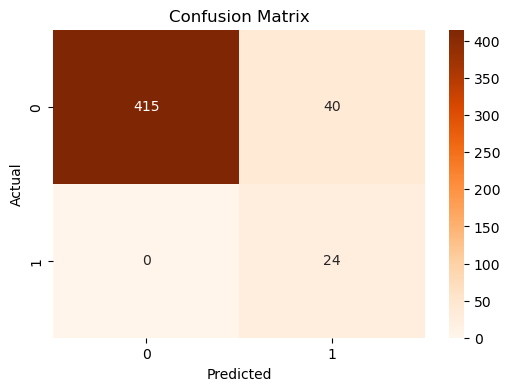

In [131]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [133]:
analysis = test_data_2[['won']]
analysis['prediction'] = y_pred
analysis['probability'] = lr_model.predict_proba(X_test)[:,1]
analysis['year'] = model_df_copy['year']
analysis['position'] = model_df_copy['positionOrder']

C:\Users\Maria\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [139]:
vars = train_data_2.drop(columns = ['won', 'podium', 'top10', 'positionOrder', 'date', 'code']).columns
vars = vars.to_list()

In [141]:
pd.DataFrame({
    'variable': vars,
    'coef': lr_model.coef_[0]
}).sort_values('coef', ascending=False)

,variable,coef
7,wins,2.870885
4,driverId,0.255905
14,win_percentage_on_circuit,0.250775
15,top_3_finishes_on_circuit,0.171560
10,YTD_avg_finish_pos,0.143836
5,constructorId,0.138645
12,avg_finish_pos_on_circuit,0.128617
16,career_win_pct,0.096073
9,previous_finish,0.024935
3,circuitId,-0.073012


Logistic Regression on 2023-2025 data (with prerace sessions): work in progress!

In [ ]:
model2 = sessions_pivot
model2[['meeting_key', 'driver_number']] = #model2[['meeting_key', 'driver_number']].astype(str)

In [ ]:
train_data_3 = model2[model2['year'] < 2025]
test_data_3 = model2[model2['year'] == 2025]

In [ ]:
X_train = train_data_3.drop(columns = ['race'])
y_train = train_data_3['race']
X_test = test_data_3.drop(columns = ['race'])
y_test = test_data_3['race']

In [ ]:
lr_model = LogisticRegression(class_weight = 'balanced', max_iter=1500, random_state=42)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

LGBM Regressor

In [71]:
train_data_1 = model_df[model_df['year'] < 2024]
test_data_1 = model_df[model_df['year'] == 2024]

In [99]:
X_train = train_data_1.drop(columns = ['won', 'podium', 'top10', 'positionOrder', 'date', 'code'])
y_train = train_data_1['won']
X_test = test_data_1.drop(columns = ['won', 'podium', 'top10', 'positionOrder', 'date', 'code'])
y_test = test_data_1['won']

In [113]:
#best for win prediction
params = {
'objective': 'regression', #l2 loss; performing slightly better than 'binary' (logloss)
'boosting_type': 'gbdt', #default
'num_iterations': 1500, #default: 100
'num_leaves': 50, #default: 31
'learning_rate': 0.06, #default: 0.1; reducing learning rate and increasing num_iterations can help accuracy
'feature_fraction': 0.9, #default; can be reduced to speed up training or reduce overfitting
'max_depth': -1, #default
'max_bin': 255, #default
}
reg = lgb.LGBMClassifier(**params)
reg.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 9227, number of used features: 18
[LightGBM] [Info] Start training from score 0.047469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMClassifier(feature_fraction=0.9, learning_rate=0.06, max_bin=255,
               num_iterations=1500, num_leaves=50, objective='regression')

In [83]:
#best for podium prediction
params = {
'objective': 'regression', #performing slightly better than 'binary'
'boosting_type': 'gbdt', #default
'num_iterations': 1500, #default: 100
'num_leaves': 50, #default: 31
'learning_rate': 0.5, #default: 0.1; reducing learning rate and increasing num_iterations can help accuracy
'feature_fraction': 0.9, #default; can be reduced to speed up training or reduce overfitting
'max_depth': -1, #default
'max_bin': 255, #default
}
reg = lgb.LGBMClassifier(**params)
reg.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 9227, number of used features: 18
[LightGBM] [Info] Start training from score 0.142408


LGBMClassifier(feature_fraction=0.9, learning_rate=0.5, max_bin=255,
               num_iterations=1500, num_leaves=50, objective='regression')

In [91]:
#best for top10 prediction
params = {
'objective': 'regression', #performing slightly better than 'binary'
'boosting_type': 'gbdt', #default
'num_iterations': 1000, #default: 100
'num_leaves': 50, #default: 31
'learning_rate': 0.5, #default: 0.1; reducing learning rate and increasing num_iterations can help accuracy
'feature_fraction': 0.9, #default; can be reduced to speed up training or reduce overfitting
'max_depth': -1, #default
'max_bin': 255, #default
}
reg = lgb.LGBMClassifier(**params)
reg.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 9227, number of used features: 18
[LightGBM] [Info] Start training from score 0.474694


LGBMClassifier(feature_fraction=0.9, learning_rate=0.5, max_bin=255,
               num_iterations=1000, num_leaves=50, objective='regression')

In [115]:
y_pred = reg.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       455
           1       0.67      1.00      0.80        24

    accuracy                           0.97       479
   macro avg       0.83      0.99      0.89       479
weighted avg       0.98      0.97      0.98       479



Accuracy: 0.9749
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       455
           1       0.67      1.00      0.80        24

    accuracy                           0.97       479
   macro avg       0.83      0.99      0.89       479
weighted avg       0.98      0.97      0.98       479



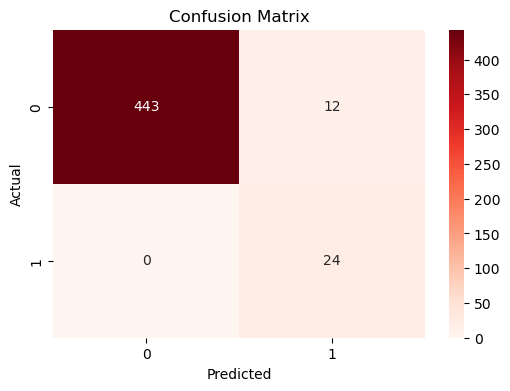

In [117]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds',
            xticklabels=reg.classes_,
            yticklabels=reg.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#run for each prediction
#analysis['won'] = test_data_1[['won']]
analysis['win_prediction'] = y_pred
analysis['win_probability'] = reg.predict_proba(X_test)[:,1]

In [ ]:
#analysis['podium'] = test_data_1[['podium']]
analysis['podium_prediction'] = y_pred
analysis['podium_probability'] = reg.predict_proba(X_test)[:,1]

In [ ]:
#analysis['top10'] = test_data_1[['top10']]
analysis['top10_prediction'] = y_pred
analysis['top10_probability'] = reg.predict_proba(X_test)[:,1]

In [ ]:
predictions_2024 = test_data_1.join(analysis, how='left')

In [ ]:
#saving to csv to use with Streamlit app
os.makedirs('../data', exist_ok=True)  
predictions_2024.to_csv('../data/predictions_2024.csv', index=False)

LGBM Classifier

In [ ]:
X_train = train_data_1.drop(columns = ['won', 'podium', 'top10', 'positionOrder', 'date', 'code'])
y_train = train_data_1['positionOrder']
X_test = test_data_1.drop(columns = ['won', 'podium', 'top10', 'positionOrder', 'date', 'code'])
y_test = test_data_1['positionOrder']

In [ ]:
params = {
'objective': 'multiclass', #predicting placement, 1-20
'boosting_type': 'gbdt', #default
'num_leaves': 31, #default
'learning_rate': 0.1, #default
'feature_fraction': 0.9, #default; can be reduced to speed up training or reduce overfitting
'class_label': 'weight'
}
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))